In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import GPy

from kernels import rbf
from gp_plot import plot_gp
from likelihood_classes import Probit
from gaussian_processes import gaussian_process_classifier

In [2]:
# Global Variables
np.random.seed(1)

# Gaussian Process Classification

Unlike in the case of regression where we placed a gaussian prior on the noise $\epsilon$ of output values of the input data $y$, it is not reasonable to do the same in the case of classification, where we perceive a decision boundary on the data. Since we do not assume Gaussian distributed likelihood, we make a few modifications and assumptions in order to utilize the Gaussian Process framework.

### Latent Functions

Instead of placing a Gaussian prior on the probability function $\pi$, we instead place a Gaussian prior on the _latent function_ $f$, and then derive the probabilities on input data $x$ by squashing the values of $f$(which may not be between 0 and 1) under a response function $\sigma$ and evaluate $\pi = \sigma(f(x))$. The choice of the response function varies, but good properties arise under appropriate choices of such functions, such as concavity under functions such as the sigmoid and Gaussian cumulative distribution function(CDF). IN this example notebook, we will be using the Gaussian CDF to model the likelihood of $p(y=+1|f)$.

### Approximation Methods
After placing a Gaussian prior on the latent functions, we now wish to infer the probabilities of a class $y_i$ given new input data. More formally, the inference step is given by:

$$
\bar{\pi}_* = p(y_* = +1 |X,y,x_*) = \int \sigma(f_*)p(f_*|X,y,x_*) df_*
$$

under the Bayes Optimal classifier, where $f_*$ is the function we wish to learn. Additionally, we can decompose the second term as:

$$
p(f_*|X,y,x_*) = \int p(f_*|X, x_*, f)p(f|X,y) df
$$

While the above forms of integrals are tractable under certain cases(binary classes, concavity of the likelihood function), in most cases this equation is untractable. Therefore, instead of the exact likelihood $p(f|X, y)$, we model the following second derivative approximation over the original likelihood function:

$$
p(f|X, y) ~ q(f|X, y) = \mathcal{N}(f|\hat{f}, A^{-1}) = \exp(-\frac{1}{2}(f-\hat{f})^TA(f-\hat{f}))
$$

Which is known as the Laplace approximation, where $\hat{f} = \arg\max_f p(f|X, y)$ is the mode of the original likelihood, and $A = -\triangledown \triangledown \log p(f|X, y)|_{f=\hat{f}}$ is the Hessian matrix of the negative log posterior at the mode. Using this approximation, we have that:

$$
q(f|X, y) = \mathcal{N}(\hat{f}, (K^{-1} + W)^{-1})
$$

where $W = -\triangledown \triangledown \log p(y|f)$. Then, the mean and covariance of the function $f_*$ is given by:

$$
\bar{f_*} = K(X, X_*)^T\triangledown \log p(y | \hat{f})
$$
$$
\mathbb{V}[f_*] = K(X_*, X_*) - K(X, X_*)^T(K + W^{-1})^{-1}K(X, X_*)
$$

In our example, instead of directly evaluating the integral to produce prediction probabilities, we instead evaluate the _Maximum A Priori(MAP)_ predictions by evaluating $\sigma(\mathbb{E}_q[f_*|y])$. This is equivalent to the _averaged predictions_ that is implied by the integral as stated in the GPML textbook.

For more details, see Chapter 3, Algorithm 3.1 for Laplace mode finding and Algorithm 3.2 for Laplace approximation predictions in GPML textbook.

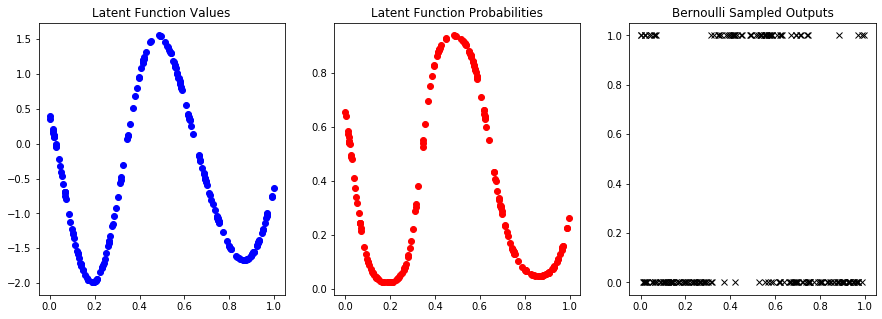

In [3]:
fig = plt.figure(figsize=(15,5))

# Draw random inputs
X_all = np.random.rand(250, 1)
X = X_all[:200]
X_new = X_all[200:]

# Latent function based on observations using Gaussian prior on latent functions f
f_all = np.random.multivariate_normal(np.zeros(250), rbf(X_all, X_all, d=2,l=0.2))
f = f_all[:200]
f_new = f_all[200:]

ax = fig.add_subplot(131)
ax.plot(X, f, 'bo')
ax.title.set_text('Latent Function Values')

# Draw the probabilities on the latent functions values by "squashing" them between 0 and 1 
# using a response function
probit = Probit() # Using a probit model function - Gaussian CDF as the response function
p_y = probit.response_function(f)

ax2 = fig.add_subplot(132)
ax2.plot(X, p_y, 'ro')
ax2.title.set_text('Latent Function Probabilities')

# Generate output labels y for the input points X w.r.t to the latent function observations
# Under the noiseless assumption|
# Sampled outputs y with Bernoulli probability distribution
y = np.random.binomial(np.ones_like(p_y, dtype=int), p_y)

ax3 = fig.add_subplot(133)
ax3.plot(X, y, 'kx')
ax3.title.set_text('Bernoulli Sampled Outputs')

In [4]:
# Evaluate probabilities on test points on latent functions
p_new = probit.response_function(f_new)
y_new = np.random.binomial(np.ones_like(p_new, dtype=int), p_new)

# Obtain prediction probabilities on new input points
pred, (mu, cov) = gaussian_process_classifier(X, y, X_new, d=2., l=0.2)

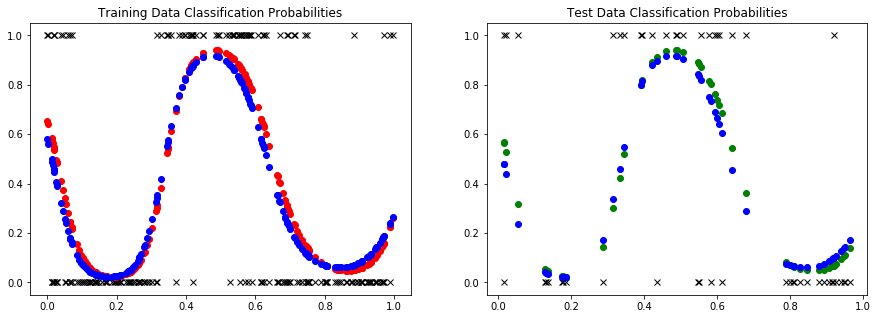

In [5]:
fig = plt.figure(figsize=(15,5))

# Training data fit
ax = fig.add_subplot(121)
ax.plot(X, y, 'kx')
ax.plot(X, p_y, 'ro')
f_bar, _ = gaussian_process_classifier(X, y, X, d=2., l=0.2)
ax.plot(X, f_bar, 'bo')
ax.title.set_text('Training Data Classification Probabilities')

# Test data fit
ax2 = fig.add_subplot(122)
ax2.plot(X_new, y_new, 'kx')
ax2.plot(X_new, p_new, 'go')
ax2.plot(X_new, pred, 'bo')
ax2.title.set_text('Test Data Classification Probabilities')